<a href="https://colab.research.google.com/github/escuccim/pytorch-face-autoencoder/blob/master/eas7_faces_3_1_g.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adding some longer residual connections to try to preserve some small details which seem to be getting lost; added batch norm; replaced 6x5 convolution with global average pool followed by 1x1 convolution.

Erased some of the training output for version 3.1 to keep size of notebook manageable.

**3.1g** - Now that the autoencoder seems to be close to overfitting the training data, I'm going to try to add an adversarial network to it to see how that works.

In [0]:
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
%matplotlib inline
import zipfile
import os

In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [4]:
!gsutil cp gs://{bucket_name}/model_30_trained.pt ./model_3g.pt
# !gsutil cp gs://{bucket_name}/model_3g0.pt ./model_3g.pt
# !gsutil cp gs://{bucket_name}/disc_model_30.pt ./disc_model_3.pt

Copying gs://pneumonia/model_30_trained.pt...
\ [1 files][294.9 MiB/294.9 MiB]                                                
Operation completed over 1 objects/294.9 MiB.                                    


In [5]:
if not os.path.exists("celeba-dataset.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
  zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

Copying gs://pneumonia/celeba-dataset.zip...
\ [1 files][  1.2 GiB/  1.2 GiB]   95.7 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [6]:
if not os.path.exists("Training_Pictures.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
  zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

--2019-06-10 05:33:22--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.156.33
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.156.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1073596 (1.0M) [application/zip]
Saving to: ‘Training_Pictures.zip’

Training_Pictures.z 100%[===================>]   1.02M  1.67MB/s    in 0.6s    

2019-06-10 05:33:23 (1.67 MB/s) - ‘Training_Pictures.zip’ saved [1073596/1073596]



In [7]:
if not os.path.exists("crop_part1.tar.gz"):
  !gsutil cp gs://{bucket_name}/crop_part1.tar.gz ./crop_part1.tar.gz
  !tar -xf crop_part1.tar.gz -C data/images
  
# if not os.path.exists("imdb_images3.zip"):
#   !gsutil cp gs://{bucket_name}/imdb_images3.zip ./imdb_images3.zip
#   zip_ref = zipfile.ZipFile('imdb_images3.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()    

Copying gs://pneumonia/wiki_images2.zip...
/ [1 files][160.5 MiB/160.5 MiB]                                                
Operation completed over 1 objects/160.5 MiB.                                    
Copying gs://pneumonia/imdb_images3.zip...
/ [1 files][  1.5 GiB/  1.5 GiB]   94.0 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


In [8]:
# get test data
# if not os.path.exists("faces94.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
#   zip_ref = zipfile.ZipFile('faces94.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()
  
# if not os.path.exists("faces96.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces96.zip  
#   zip_ref = zipfile.ZipFile('faces96.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()

if not os.path.exists("faces95.zip"):
  !wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip  
  zip_ref = zipfile.ZipFile('faces95.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()
  
if not os.path.exists("GWB_200x200_JPEG.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
  zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()    

if not os.path.exists("wiki_images2.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images2.zip ./wiki_images.zip
  zip_ref = zipfile.ZipFile('wiki_images.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()

--2019-06-10 05:34:28--  https://cswww.essex.ac.uk/mv/allfaces/faces95.zip
Resolving cswww.essex.ac.uk (cswww.essex.ac.uk)... 155.245.92.179
Connecting to cswww.essex.ac.uk (cswww.essex.ac.uk)|155.245.92.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6425534 (6.1M) [application/zip]
Saving to: ‘faces95.zip’

faces95.zip         100%[===================>]   6.13M  7.49MB/s    in 0.8s    

2019-06-10 05:34:30 (7.49 MB/s) - ‘faces95.zip’ saved [6425534/6425534]

--2019-06-10 05:34:31--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.156.13
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.156.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15795698 (15M) [application/zip]
Saving to: ‘GWB_200x200_JPEG.zip’

GWB_200x200_JPEG.zi 100%[===================>]  15.06M  12.2MB/s    in 1.2s    

2019-06-10 05:34:33 (12

In [0]:
BATCH_SIZE = 24
data_path = "data/images"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=8, translate=(0.075,0.075), scale=(0.85,1.15), shear=4, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.RandomResizedCrop((192,160), scale=(0.8, 1.20)),
      torchvision.transforms.ToTensor(),
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop((192,160), scale=(0.95, 1.05)),
      torchvision.transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
) 

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

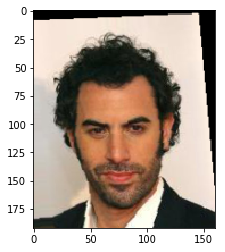

In [47]:
for (images, _) in train_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

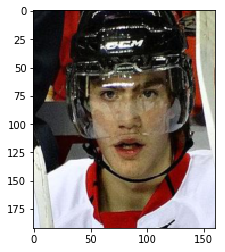

In [48]:
for (images, _) in test_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

In [49]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 212421
    Root location: data/images

In [50]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 17629
    Root location: data/test_images

In [0]:
def output_size(i, k=3, p=2, s=1, d=1):
    o = (i + 2*p - k - (k-1)*(d-1))/s + 1
    return o
  
output_size(i=64, k=3, p=1)

64.0

### Bigger Model

In [0]:
epoch_list = [0]

In [0]:
def vae_loss(x, x_hat, mu=None, logvar=None, d_faked=None, debug=False):
    beta_mse = 20.0
    beta_g = 0.03
    # MSE for reconstructions
    MSE = nn.functional.mse_loss(x, x_hat) * beta_mse
    
    if debug:
      print("Raw MSE:", MSE / beta_mse)
      print("Adj MSE:", MSE)
    
    # weight the MSE loss higher so the discriminator loss doesn't overwhelm it
    if d_faked is not None:
        if use_cuda:
          ones = torch.ones(d_faked.shape[0]).cuda()
        else:
          ones = torch.ones(d_faked.shape[0])
      
        g_loss =  nn.functional.binary_cross_entropy_with_logits(d_faked, ones, reduction="mean")
        if debug:
          print("Raw Disc Loss:", g_loss)
          print("Adj Disc Loss:", g_loss * beta_g)
        
        MSE += (g_loss * beta_g)
        
    return MSE

def disc_loss(d_true, d_faked):
    if use_cuda:
      ones = torch.ones(d_true.shape[0]).cuda()
      zeros = torch.zeros(d_true.shape[0]).cuda()
    else:
      ones = torch.ones(d_true.shape[0])
      zeros = torch.zeros(d_true.shape[0])
    
    d_loss_real = nn.functional.binary_cross_entropy_with_logits(d_true, ones, reduction="mean")
    d_loss_fake = nn.functional.binary_cross_entropy_with_logits(d_faked, zeros, reduction="mean")
    d_loss = d_loss_real + d_loss_fake

    return d_loss

def disc_loss2(labels, logits):
    d_loss = nn.functional.binary_cross_entropy_with_logits(logits, labels, reduction="mean")
    
    return d_loss  
  
def train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, train_gen=True, train_disc=True, test_loader=None, print_metrics=1000, extra_gen_train=2, plot_images=4000, num_epochs=10, display_images=5, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_3.pt", g_save_path="model_3g.pt"):
    
    # if we aren't training the generator we don't need to train the discriminator less than every epoch
    if train_gen is False:
      extra_gen_train = 1
      
    try:
      for epoch in range(num_epochs):
          discriminator.train()
          generator.train()
          d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          d_tr_loss = 0.0
          g_tr_loss = 0.0
          d_test_loss = 0.0
          g_test_loss = 0.0
          test_loss = 0.0
          test_d_loss = 0
          
          test_d_acc = []
          batch_losses = []
          batch_accuracies = []
          
          for i, (inputs, _) in enumerate(train_loader):
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              d_optimizer.zero_grad()
              g_optimizer.zero_grad()
              
              # generate our fake images
              if train_gen:
                recon, code, logvar = generator(inputs)
              else:
                with torch.no_grad():
                  recon, code, logvar = generator(inputs)
              
              ## TRYING STUFF
              # concat the real images and the recons
              disc_batch = torch.cat((inputs, recon), 0)
              
              # feed the batch to the discriminator
              d_logits = discriminator(disc_batch)
              
              batch_size = d_logits.shape[0] // 2
              if use_cuda:
                  ones = torch.ones(batch_size).cuda()
                  zeros = torch.zeros(batch_size).cuda()
              else:
                  ones = torch.ones(batch_size)
                  zeros = torch.zeros(batch_size)

              labels = torch.cat((ones, zeros))
              
              # separate the logits back
#               real_logits = d_logits[:BATCH_SIZE]
#               faked_logits = d_logits[BATCH_SIZE:]
              
#               # feed the fake images into the discriminator
#               faked_logits = discriminator(recon)
                  
#               # feed the real images into the discriminator
#               real_logits = discriminator(inputs)
#               d_loss = disc_loss(real_logits, faked_logits)
              d_loss = disc_loss2(labels, d_logits)
              
              # update the discriminator every other step to give the generator time to catch up
              if train_disc and i % extra_gen_train == 0:
                d_loss.backward(retain_graph=True)
                d_optimizer.step()

              # calculate the accuracy of our discriminator
#               fake_preds = torch.sigmoid(faked_logits)
#               real_preds = torch.sigmoid(real_logits)
              d_preds = torch.sigmoid(d_logits).round()
              
              d_accuracy = torch.mean((d_preds == labels).double())
#               fake_acc = torch.sum(fake_preds < 0.5).double()
#               real_acc = torch.sum(real_preds >= 0.5).double()
#               d_accuracy = (fake_acc + real_acc) / (BATCH_SIZE * 2.0)
              batch_accuracies.append(d_accuracy.item())
              
              # update the generator, use no grad if we aren't training the generator to speed things up and save RAM
              if train_gen:
                # separate the fake logits back out so we can feed them to the gen loss function
                faked_logits = d_logits[batch_size:]
                g_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)
                g_loss.backward()
                g_optimizer.step()
              else:
                with torch.no_grad():
                  g_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)
              
              g_tr_loss += g_loss.item()
                  
              d_tr_loss += d_loss.item()
              batch_losses.append(g_loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "gen loss:", g_loss.item(), "disc loss:", d_loss.item(), "disc acc:", np.mean(batch_accuracies))

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print(e)

              torch.save(discriminator.state_dict(), d_save_path)
              torch.save(generator.state_dict(), g_save_path)
          
          if test_loader is not None:
            generator.eval()
            discriminator.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()
                
                # autoencode the input images
                recon, code, logvar = generator(inputs)

                loss = vae_loss(inputs, recon, code, logvar=logvar)
                test_loss += loss.item()
                
                # combine the real and recon images into a single batch for the discriminator
                disc_batch = torch.cat((inputs, recon), 0)

                # feed the batch to the discriminator
                d_logits = discriminator(disc_batch)
                
                # create labels for the disc loss function
                batch_size = d_logits.shape[0] // 2
                if use_cuda:
                    ones = torch.ones(batch_size).cuda()
                    zeros = torch.zeros(batch_size).cuda()
                else:
                    ones = torch.ones(batch_size)
                    zeros = torch.zeros(batch_size)

                labels = torch.cat((ones, zeros))
                
                # run the discriminator loss function
                d_loss = disc_loss2(labels, d_logits)
                
#                 # test the discriminator
#                 faked_logits = discriminator(recon)                
#                 real_logits = discriminator(inputs)
#                 d_loss = disc_loss(real_logits, faked_logits)
                test_d_loss += d_loss.item()
                
                # calculate the accuracy of our discriminator
#                 fake_preds = torch.sigmoid(faked_logits)
#                 real_preds = torch.sigmoid(real_logits)

#                 fake_acc = torch.sum(fake_preds < 0.5).double()
#                 real_acc = torch.sum(real_preds >= 0.5).double()
#                 d_accuracy = (fake_acc + real_acc) / (BATCH_SIZE * 2.0)
                d_preds = torch.sigmoid(d_logits).round()
              
                d_accuracy = torch.mean((d_preds == labels).double())
                test_d_acc.append(d_accuracy.item())
                
            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Gen Train Loss:", g_tr_loss, "Disc Train Loss:", d_tr_loss, "Test Loss:", test_loss, "Avg Tr Disc Acc:", np.mean(batch_accuracies), "Avg Te Disc Acc:", np.mean(test_d_acc))
          
          epoch_list.append(epoch)
          
          if g_scheduler is not None and epoch % 5 == 0 and epoch > 1:
              g_scheduler.step()
              
          if d_scheduler is not None and epoch % 5 == 0 and epoch > 1:
              d_scheduler.step()
 
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(generator.state_dict(), g_save_path)
      torch.save(discriminator.state_dict(), d_save_path)
      !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
      !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      return 
    
    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
        
def train(model, train_loader, optimizer, test_loader=None, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, scheduler=None, save_path="model_3g.pt"):
    try:
      for epoch in range(num_epochs):
          model.train()
          upload_path = save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          tr_loss = 0.0
          test_loss = 0
          batch_losses = []
          for i, (inputs, _) in enumerate(train_loader):
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              optimizer.zero_grad()

              recon, code, logvar = model(inputs)
              if model.variational:
                  loss = vae_loss(inputs, recon, code, logvar=logvar)
              else:  
                  loss = vae_loss(inputs, recon, code, logvar=None)

              loss.backward()
              optimizer.step()

              tr_loss += loss.item()
              batch_losses.append(loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "loss:", loss.item())

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print(e)

              torch.save(model.state_dict(), save_path)
#               !gsutil cp ./model.pt gs://{bucket_name}/
          
          if test_loader is not None:
            model.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()

                recon, code, logvar = model(inputs)

                if model.variational:
                    loss = vae_loss(inputs, recon, code, logvar=logvar)
                else:  
                    loss = vae_loss(inputs, recon, code, logvar=None)

                test_loss += loss.item()

            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Train Loss:", tr_loss, "Test Loss:", test_loss)
          
          epoch_list.append(epoch)
          
          if scheduler is not None and epoch % 5 == 0 and epoch > 1:
              scheduler.step()

                
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(model.state_dict(), save_path)
      !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      return 
    
    !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
    
def count_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params                

In [0]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, latent_dim, variational=False):
        super(Encoder, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.downsize1 = nn.Conv2d(96, 32, 1)
        self.bn_ds1 = nn.BatchNorm2d(32)
        
        # block 2
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.downsize2 = nn.Conv2d(192, 64, 1)
        self.bn_ds2 = nn.BatchNorm2d(64)
        
        # block 3
        self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(128)
        self.downsize3 = nn.Conv2d(384, 128, 1)
        self.bn_ds3 = nn.BatchNorm2d(128)
        
        # block 4
        self.conv10 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(256)
        self.conv11 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(256)
        self.downsize4 = nn.Conv2d(512, 256, 1)
        self.bn_ds4 = nn.BatchNorm2d(256)
        
        # block 5
        self.conv12 = nn.Conv2d(256, 384, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(384)
        self.conv13 = nn.Conv2d(384, 384, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(384)
        self.downsize5 = nn.Conv2d(768, 384, 1)
        self.bn_ds5 = nn.BatchNorm2d(384)
        
        # second path - skip from block 2 on
        self.conv14 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.bn14 = nn.BatchNorm2d(128)
        self.conv15 = nn.Conv2d(128, 128, 3, padding=1, stride=2)
        self.bn15 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Conv2d(512, latent_dim, 2) # code layer
        
        self.variational = variational
        if variational:
          self.fc2 = nn.Conv2d(512, latent_dim, 2) # variance layer
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(2)
        
        
    def encode(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        ds1 = self.relu(self.bn_ds1(self.downsize1(torch.cat((h1,h2,h3), 1))))
        mp1 = self.max_pool(ds1)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        ds2 = self.relu(self.bn_ds2(self.downsize2(torch.cat((h4,h5,h6), 1))))
        mp2 = self.max_pool(ds2)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        ds3 = self.relu(self.bn_ds3(self.downsize3(torch.cat((h7,h8,h9), 1))))
        mp3 = self.max_pool(ds3)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        ds4 = self.relu(self.bn_ds4(self.downsize4(torch.cat((h10,h11), 1))))
        mp4 = self.max_pool(ds4)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        ds5 = self.relu(self.bn_ds5(self.downsize5(torch.cat((h12,h13), 1))))
        mp5 = self.max_pool(ds5)
        
        # second path - input 64x48x40
        # output 64x12x10
        h14 = self.relu(self.bn14(self.conv14(mp2)))
        h15 = self.relu(self.bn15(self.conv15(h14)))
        # output 64x6x5
        mp6 = self.max_pool(h15)
        
        # concat the paths
        concat = self.gap(torch.cat((mp5, mp6), 1))
        
        
        # input 4x4x64 - output latent_dimx1
        code = self.fc1(concat)
        
        if self.variational:
          logvar = self.fc2(concat)
        else:
          logvar = None
  
        return code, logvar
  
    def forward(self, x):
        code, logvar = self.encode(x)
        return code, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.ConvTranspose2d(latent_dim, 512, (6,5), stride=1)
        self.bn0 = nn.BatchNorm2d(512)
        self.deconv1 = nn.ConvTranspose2d(512, 384, 2, stride=2, output_padding=0)
        self.bn1 = nn.BatchNorm2d(384)
        self.deconv3 = nn.ConvTranspose2d(384, 256, 2, stride=2, output_padding=0)
        self.bn3 = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 224, 2, stride=2, output_padding=0)
        self.bn4 = nn.BatchNorm2d(224)
        self.deconv5 = nn.ConvTranspose2d(224, 192, 2, stride=2, output_padding=0)
        self.bn5 = nn.BatchNorm2d(192)
        self.deconv6 = nn.ConvTranspose2d(192, 128, 2, stride=2, output_padding=0)
        self.bn6 = nn.BatchNorm2d(128)
        self.deconv8 = nn.Conv2d(128, 3, 1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
  
    def decode(self, x):
        # input latent_dimx1 - output 2048x1
        h0 = self.relu(self.bn0(self.fc1(x)))
        
        # in 5x5 - out 10x10
        h1 = self.relu(self.bn1(self.deconv1(h0)))
        
        # in 10x10 - out 20x20
        h3 = self.relu(self.bn3(self.deconv3(h1)))
        h4 = self.relu(self.bn4(self.deconv4(h3)))
        h5 = self.relu(self.bn5(self.deconv5(h4)))
        h6 = self.relu(self.bn6(self.deconv6(h5)))
        h8 = self.deconv8(h6)
      
        return self.sigmoid(h8)
    
    def forward(self, x):
        return self.decode(x)
    
# a model that uses the Encoder and Decoder
class SingleModel(nn.Module):
    def __init__(self, encoder, decoder, variational=False):
        super(SingleModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.variational = variational

    def sample(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def forward(self, X):
        mu, logvar = encoder(X)

        if self.training and logvar is not None:
            z = self.sample(mu, logvar)
        else:
            z = mu
            
        recon = self.decoder(z)
        
        return recon, mu, logvar
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 48, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(48, 48, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 48, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(48)
        
        # block 2
        self.conv4 = nn.Conv2d(48, 96, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(96)
        self.conv5 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(96)
        self.conv6 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(96)
        
        # block 3
        self.conv7 = nn.Conv2d(96, 192, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(192)
        self.conv8 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(192)
        self.conv9 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(192)
        
        # block 4
        self.conv10 = nn.Conv2d(192, 384, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(384)
        self.conv11 = nn.Conv2d(384, 384, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(384)
        
        # block 5
        self.conv12 = nn.Conv2d(384, 512, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(512)
        self.conv13 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(1024)
        
        self.fc1 = nn.Conv2d(1024, 2048, 1) # code layer
        self.bn14 = nn.BatchNorm2d(2048)
        self.fc2 = nn.Conv2d(2048, 1, 1)
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(1)
        
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.50)
        
    def discriminate(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        mp1 = self.max_pool(h3)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        mp2 = self.max_pool(h6)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        mp3 = self.max_pool(h9)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        mp4 = self.max_pool(h11)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        mp5 = self.max_pool(h13)
        gap = self.dropout1(self.gap(mp5))
        
        # input 4x4x64 - output latent_dimx1
        fc1 = self.dropout2(self.relu(self.bn14(self.fc1(gap))))
        logits = self.fc2(fc1)
        
        return torch.squeeze(logits)
  
    def forward(self, x):
        return self.discriminate(x)

In [13]:
from torch import optim
import numpy as np

  ## YOUR CODE HERE ##
encoder = Encoder(4096, variational=False)
decoder = Decoder(4096)
generator = SingleModel(encoder, decoder)
discriminator = Discriminator()

params = generator.parameters()

print("Autoencoder Params:", count_params(generator))
print("Discriminator Params:", count_params(discriminator))

# run on GPU
use_cuda = True
  
if use_cuda and torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    
g_optimizer = optim.Adam(params, lr=0.0005)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00000001)
g_scheduler = optim.lr_scheduler.ExponentialLR(g_optimizer, gamma=0.95)
d_scheduler = optim.lr_scheduler.ExponentialLR(d_optimizer, gamma=0.95)

try:
  generator.load_state_dict(torch.load("model_3g.pt"))
  print("Generator loaded")
except:
  print("Error loading Generator")

try:
    discriminator.load_state_dict(torch.load("disc_model_3.pt"))
    print("Discriminator loaded")
except:
    print("Error loading discriminator")

Autoencoder Params: 77289667
Discriminator Params: 11673569
Generator loaded
Error loading discriminator


	Epoch 1 batch 1000 gen loss: 0.13294276595115662 disc loss: 0.5663896799087524 disc acc: 0.8105852722425709
	Epoch 1 batch 2000 gen loss: 0.12805205583572388 disc loss: 0.5448542833328247 disc acc: 0.7628894113748893
	Epoch 1 batch 3000 gen loss: 0.12113487720489502 disc loss: 0.6082028746604919 disc acc: 0.7364906361888286


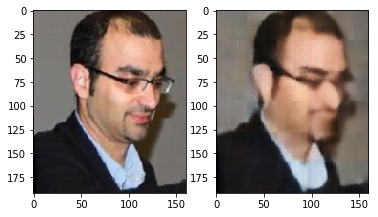

	Epoch 1 batch 4000 gen loss: 0.10170574486255646 disc loss: 0.6266416907310486 disc acc: 0.7187838671266683
	Epoch 1 batch 5000 gen loss: 0.11328113079071045 disc loss: 0.6260375380516052 disc acc: 0.7069961218499697
	Epoch 1 batch 6000 gen loss: 0.11669892072677612 disc loss: 0.6275758743286133 disc acc: 0.6978246889076661


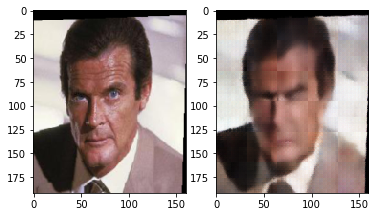

	Epoch 1 batch 7000 gen loss: 0.10493569821119308 disc loss: 0.6122223734855652 disc acc: 0.6895622259497838
	Epoch 1 batch 8000 gen loss: 0.10060280561447144 disc loss: 0.6667850017547607 disc acc: 0.6821361074850117
	Epoch 1 batch 9000 gen loss: 0.11666113138198853 disc loss: 0.6651949882507324 disc acc: 0.6758045603768148


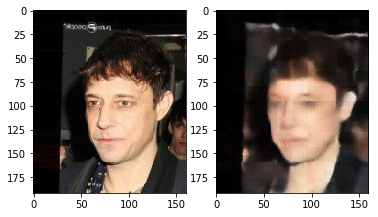

	Epoch 1 batch 10000 gen loss: 0.12005048990249634 disc loss: 0.6059907674789429 disc acc: 0.671122491087233
	Epoch 1 batch 11000 gen loss: 0.12095095217227936 disc loss: 0.6489760875701904 disc acc: 0.6662027135489
	Epoch 1 batch 12000 gen loss: 0.10124199092388153 disc loss: 0.6692526340484619 disc acc: 0.6610074357482187


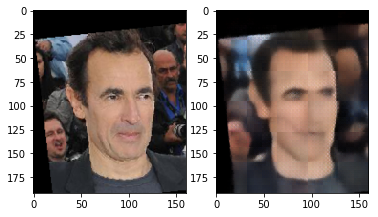

	Epoch 1 batch 13000 gen loss: 0.11448520421981812 disc loss: 0.6800586581230164 disc acc: 0.6560136595271421
	Epoch 1 batch 14000 gen loss: 0.12277072668075562 disc loss: 0.5952629446983337 disc acc: 0.651286832256561
	Epoch 1 batch 15000 gen loss: 0.11615698784589767 disc loss: 0.5952423214912415 disc acc: 0.6471707634598018


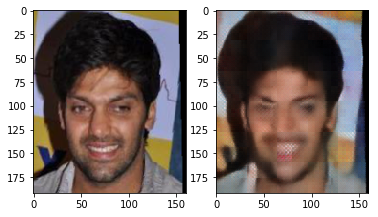

	Epoch 1 batch 16000 gen loss: 0.0969526618719101 disc loss: 0.7033695578575134 disc acc: 0.6436407812176956


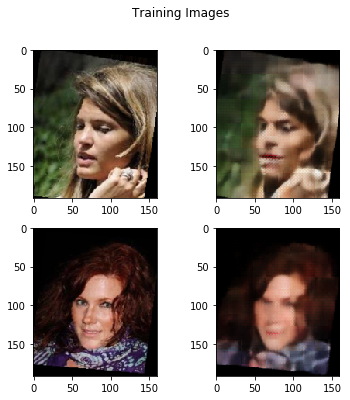

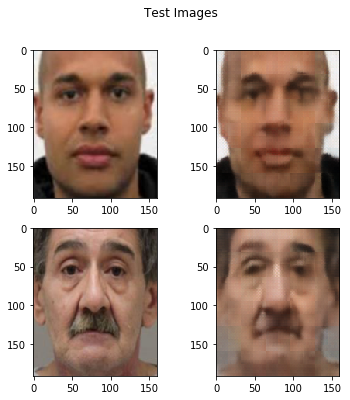

Epoch: 1 Gen Train Loss: 1917.5204926803708 Disc Train Loss: 10261.387840360403 Test Loss: 15.996040806174278 Avg Tr Disc Acc: 0.642071743111014 Avg Te Disc Acc: 0.6745218579234973
Copying file://model_3g.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/294.9 MiB.                          

In [39]:
# once the discriminator is doing pretty well we'll start to train the networks together
# train the discriminator to the point where it has useful results
train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, num_epochs=1, train_gen=True, train_disc=True, test_loader=test_loader, print_metrics=1000, extra_gen_train=16, plot_images=3000, display_images=1, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="model_3g.pt")

In [51]:
# once the discriminator is doing pretty well we'll start to train the networks together
# train the discriminator to the point where it has useful results
train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, num_epochs=1, train_gen=True, train_disc=True, test_loader=test_loader, print_metrics=1000, extra_gen_train=16, plot_images=3000, display_images=1, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="model_3g.pt")

	Epoch 2 batch 1000 gen loss: 0.11622259765863419 disc loss: 0.5129566788673401 disc acc: 0.740613575185557
Interrupting... Saving model...
Copying file://model_3g.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/294.9 MiB.                                    
Copying file://disc_model_3.pt

In [0]:
# once the discriminator is doing pretty well we'll start to train the networks together
# train the discriminator to the point where it has useful results
train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, train_gen=True, train_disc=True, test_loader=test_loader, print_metrics=500, extra_gen_train=2, plot_images=2000, num_epochs=1, display_images=1000, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="model_3g.pt")

In [0]:
# once the discriminator is doing pretty well we'll start to train the networks together
# train the discriminator to the point where it has useful results
train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, num_epochs=1, train_gen=True, train_disc=True, test_loader=test_loader, print_metrics=1000, extra_gen_train=16, plot_images=3000, display_images=1, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="model_3g.pt")

In [37]:
## CHECK MEAN AND VARIANCE OF CODES
with torch.no_grad():
    for (inputs, _) in test_loader:
      inputs = inputs.cuda()
      generator.encoder.eval()
      generator.decoder.eval()
      # encode the images and reconstruct them
      codes, logvar = generator.encoder(inputs)
      recon = generator.decoder(codes)
      disc_batch = torch.cat((inputs, recon), 0)
              
      # feed the batch to the discriminator
      d_logits = discriminator(disc_batch)
      d_preds = torch.sigmoid(d_logits).round()
      
      batch_size = int(d_logits.shape[0] / 2)
      print(batch_size)
      if use_cuda:
          ones = torch.ones(batch_size).cuda()
          zeros = torch.zeros(batch_size).cuda()
      else:
          ones = torch.ones(batch_size)
          zeros = torch.zeros(batch_size)

      labels = torch.cat((ones, zeros))
      
      
      d_loss = disc_loss2(labels, d_logits)
      print("Disc loss:", d_loss)
      faked_logits = d_logits[batch_size:]
      vae_loss(inputs.cuda(), recon, codes, logvar=logvar, d_faked = faked_logits, debug = True)
      break

32
D_loss: tensor(0.5087, device='cuda:0')
Raw MSE: tensor(0.0043, device='cuda:0')
Adj MSE: tensor(0.0856, device='cuda:0')
Raw Disc Loss: tensor(0.8700, device='cuda:0')
Adj Disc Loss: tensor(0.0435, device='cuda:0')


In [0]:
# once the discriminator is doing pretty well we'll start to train the networks together
# train the discriminator to the point where it has useful results
train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, train_gen=True, train_disc=False, test_loader=test_loader, print_metrics=2000, extra_gen_train=128, plot_images=4000, num_epochs=1, display_images=1, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="model_3g.pt")

In [0]:
!mkdir data/Train
!cp -r data/images/Training_Pictures data/Train/Images

In [0]:
train_dataset2 = torchvision.datasets.ImageFolder(
        root="data/Train",
        transform=transform
    )

train_loader2 = torch.utils.data.DataLoader(
    train_dataset2,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

In [0]:
train(model, train_loader=train_loader2, optimizer=optimizer, print_metrics=10, plot_images=1, num_epochs=25, display_images=1, scheduler=scheduler)

In [0]:
noise = np.random.normal(loc=0.3, scale=7.5, size=4096).reshape((1,4096,1,1))
image = model.decoder(torch.from_numpy(noise).cuda().float())
plt.imshow(image[0].cpu().detach().permute(1,2,0))
plt.show()

In [0]:
# # download and unzip the data
# url = "https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_64x64.zip"
# if not os.path.exists("gwb_images.zip"):
#   wget.download(url, 'gwb_images.zip')

#   zip_ref = zipfile.ZipFile('gwb_images.zip', 'r')
#   zip_ref.extractall('data/gwb')
#   zip_ref.close()

In [0]:
# use the existing encoder to create a GWBush decoder
from torch import optim
import numpy as np

  ## YOUR CODE HERE ##
encoder = model.encoder
gwb_decoder = Decoder(2048)
gwb_model = SingleModel(encoder, gwb_decoder)
gwb_params = gwb_model.decoder.parameters()

# run on GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    gwb_decoder.cuda()
    gwb_model.cuda()
    
optimizer = optim.Adam(gwb_params, lr=0.002)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)    

In [0]:
# gwb dataset
BATCH_SIZE = 64
data_path = "data/gwb"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomChoice([
        torchvision.transforms.RandomAffine(degrees=7, translate=(0.05,0.05), scale=(0.9,1.1), shear=3, resample=False, fillcolor=0),
        torchvision.transforms.RandomResizedCrop((192,160), scale=(0.90, 1.1)),
      ]),
    torchvision.transforms.ToTensor(),
    ])

gwb_train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

gwb_train_loader2 = torch.utils.data.DataLoader(
    gwb_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [0]:
for (images, _) in gwb_train_loader2:
  plt.imshow(images[0].permute(1,2,0))
  break

In [0]:
train(gwb_model, gwb_train_loader2, optimizer, print_metrics=0, num_epochs=200, display_images=20, scheduler=scheduler, save_path="./gwb_model.pt")

In [22]:
## MAKE SURE WE CAN CONCAT THE RECON AND THE ORIGINAL IMAGES PROPERLY
with torch.no_grad():
    for (inputs, _) in test_loader:
      generator.encoder.eval()
      generator.decoder.eval()
      # encode the images and reconstruct them
      codes, logvar = generator.encoder(inputs.cuda())
      recon = generator.decoder(codes)
      vae_loss(inputs.cuda(), recon, codes, logvar=logvar)
      print("Inputs:", inputs.shape)
      print("Recon:", recon.shape)
      print(torch.cat((recon, inputs.cuda()), 0).shape)
      print("Mean:", torch.mean(codes))
      print("Std:", codes.std())
      break

Inputs: torch.Size([32, 3, 192, 160])
Recon: torch.Size([32, 3, 192, 160])
torch.Size([64, 3, 192, 160])
Mean: tensor(-0.0177, device='cuda:0')
Std: tensor(2.1738, device='cuda:0')
